# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import libraries
# %load_ext cudf.pandas
import pandas as pd

import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.tuner import WarmStartConfig, WarmStartTypes
import boto3

import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector
from imblearn.over_sampling import SMOTEN, SMOTE, RandomOverSampler
from mlsmote import MLSMOTE
from sklearn.ensemble import RandomForestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from tempfile import mkdtemp
from shutil import rmtree

from src.config import *
from src.helper import *

# from custom_transformer import StartingVerbExtractor

# import logging
# logger = logging.getLogger(__name__)

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 300)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/juanitasmith/Library/Application Support/sagemaker/config.yaml


In [3]:
print(boto3.__version__)
print(sagemaker.__version__)

1.34.82
2.221.1


In [4]:
# create sagemaker session
sagemaker_session = sagemaker.Session()

# assign sagemaker role
# detect if notebook is running locally or in a cluster
# a=os.popen('hostname').read()
# if 'local' in a:
#     print('Notebook is running locally')
#     role = sagemaker_role 
# else:
#     role = sagemaker.get_execution_role()
#     print('Notebook is running on a cluster')

# set default bucket
bucket = sagemaker_session.default_bucket()
print('Bucket: {}'.format(bucket))

region = sagemaker_session.boto_region_name
print('Region: {}'.format(region))

output_path = 's3://{}/{}/output'.format(bucket, prefix)
print('S3 Output path: {}'.format(output_path))

# pointers to location of training, validation and testing datasets
s3_path_train = 's3://{}/{}/{}'.format(bucket, prefix, path_train[3:])
print('S3 Training path: {}'.format(s3_path_train))

s3_path_validation = 's3://{}/{}/{}'.format(bucket, prefix, path_validation[3:])
print('S3 Validation path: {}'.format(s3_path_validation))

s3_path_test = 's3://{}/{}/{}'.format(bucket, prefix, path_test[3:])
print('S3 Testing path: {}'.format(s3_path_test))

Bucket: sagemaker-eu-west-1-588541864162
Region: eu-west-1
S3 Output path: s3://sagemaker-eu-west-1-588541864162/disaster_pipeline/output
S3 Training path: s3://sagemaker-eu-west-1-588541864162/disaster_pipeline/data/train/train
S3 Validation path: s3://sagemaker-eu-west-1-588541864162/disaster_pipeline/data/train/validation
S3 Testing path: s3://sagemaker-eu-west-1-588541864162/disaster_pipeline/data/test


In [5]:
random_state = 88

FILE_LOG = '../data/disaster_response.log'

# activate logging
# logging.basicConfig(filename=FILE_LOG, filemode='a', level=logging.INFO)

In [6]:
# load message data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
conn = engine.connect()
df = pd.read_sql('select * from messages', con=conn, index_col='id')
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25991 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 25991 non-null  object
 1   genre                   25991 non-null  object
 2   related                 25991 non-null  int64 
 3   request                 25991 non-null  int64 
 4   offer                   25991 non-null  int64 
 5   aid_related             25991 non-null  int64 
 6   medical_help            25991 non-null  int64 
 7   medical_products        25991 non-null  int64 
 8   search_and_rescue       25991 non-null  int64 
 9   security                25991 non-null  int64 
 10  military                25991 non-null  int64 
 11  water                   25991 non-null  int64 
 12  food                    25991 non-null  int64 
 13  shelter                 25991 non-null  int64 
 14  clothing                25991 non-null  int64 
 15  money  

In [8]:
# try to read message language detection and translation, if it exist
df_language = pd.DataFrame()
try:
    df_language = pd.read_sql('select * from message_language',
                              con=conn,
                              index_col='id',
                              dtype={'is_english': 'boolean'}
                              )
finally:
    pass

# df_language[df_language['is_english'] == False].sample(5)
df_language.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7400 entries, 7976 to 369
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_english   7400 non-null   boolean
 1   translation  7400 non-null   object 
dtypes: boolean(1), object(1)
memory usage: 130.1+ KB


In [9]:
# merge dataframes
if len(df_language) > 0:
    df = df.merge(df_language, on='id', how='left' )
    
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,True,
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,


In [10]:
df.tail()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30261,"The training demonstrated how to enhance micronutrient, protein and energy intake for meals using locally grown horticulture produce, rice and fish.",news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30262,A suitable candidate has been selected and OCHA Jakarta is currently working on her three month-contract starting on the 01st July 2005.,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30263,"Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30264,"Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.",news,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN
30265,"A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.",news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,NaN


In [11]:
# For messages with no translation or language detection, set is_english = True
df['is_english'] = np.where(df['is_english'].isnull(), True, df['is_english'])
df[df['is_english'] == False][:5]


,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
176,"in what field would you need me to speak creole. French, half english, ( MW? )",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"In what field would you need me to speak Creole, French, half English?"
342,"Onere and some food. Thanks for your understanding. ( Translator's note : are we getting the full messages? Most of them appear to be bits of sentences, like this one )",direct,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)"
383,K aTIS RAP CREOLE. CONTACT ME FAST. FAST VIA SMS OR CALL URGENT it is very very important because it today im gonna do wats I got to do over the bariers am allready waiting,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting."
399,Don't know what to do about estaff touterene part at the end,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,Don't know what to do about the staff routing part at the end
508,We are desperate for food and water. Our organization is Kole Zepol pou'n delivre,direct,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,We are desperate for food and water. Our organization is Kole Zepol to deliver


In [12]:
# replace message with translation if message if flagged as not being in English
df['message_new'] =  np.where((df['is_english'] == False) & (~df['translation'].isnull()),
                              df['translation'],
                              df['message'])

In [13]:
# make sure messages already in English are untouched
df[df['is_english'] == True].sample(5)

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18441,"BEIJING, July 21 (AFP) - Some 250,000 people have been uprooted by pounding rains and devastating floods sweeping across China, as the death toll steadily climbed Wednesday.",news,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,True,NaN,"BEIJING, July 21 (AFP) - Some 250,000 people have been uprooted by pounding rains and devastating floods sweeping across China, as the death toll steadily climbed Wednesday."
21083,The launch of the vaccination campaign follows a tail-off in activity for the IOM medical team running the IOM/USAID triage tent for incoming wounded at Banda Aceh's Sultan Iskandar Muda Airbase.,news,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,NaN,The launch of the vaccination campaign follows a tail-off in activity for the IOM medical team running the IOM/USAID triage tent for incoming wounded at Banda Aceh's Sultan Iskandar Muda Airbase.
17590,"* Planning for immediate, medium and long term rehabilitation and recovery action",news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,NaN,"* Planning for immediate, medium and long term rehabilitation and recovery action"
28952,"What has been gaining traction as a result is the largest extremist threat in the region's modern history: ISIS, self-proclaimed as the Islamic State, better known in the Arab world as Daesh.",news,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True,NaN,"What has been gaining traction as a result is the largest extremist threat in the region's modern history: ISIS, self-proclaimed as the Islamic State, better known in the Arab world as Daesh."
9474,is canadian ambassy give students and touristic visa ?,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,NaN,is canadian ambassy give students and touristic visa ?


In [14]:
# check that messages not in English were replaced
df[df['is_english'] == False][:5]

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
176,"in what field would you need me to speak creole. French, half english, ( MW? )",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"In what field would you need me to speak Creole, French, half English?","In what field would you need me to speak Creole, French, half English?"
342,"Onere and some food. Thanks for your understanding. ( Translator's note : are we getting the full messages? Most of them appear to be bits of sentences, like this one )",direct,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)","I need some food. Thanks for your understanding. (Translator's note: are we getting the full messages? Most of them appear to be bits of sentences, like this one)"
383,K aTIS RAP CREOLE. CONTACT ME FAST. FAST VIA SMS OR CALL URGENT it is very very important because it today im gonna do wats I got to do over the bariers am allready waiting,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,"I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting.","I need help in Creole. Contact me quickly, quickly via SMS or call, it's urgent. It is very important because today I'm going to do what I have to do over the barriers, I'm already waiting."
399,Don't know what to do about estaff touterene part at the end,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,Don't know what to do about the staff routing part at the end,Don't know what to do about the staff routing part at the end
508,We are desperate for food and water. Our organization is Kole Zepol pou'n delivre,direct,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,We are desperate for food and water. Our organization is Kole Zepol to deliver,We are desperate for food and water. Our organization is Kole Zepol to deliver


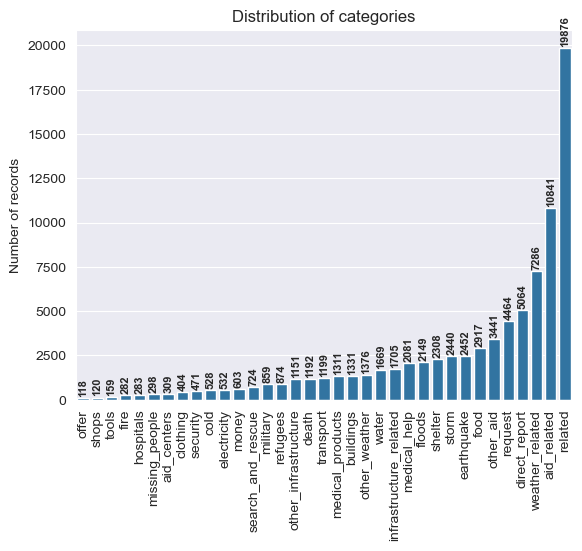

In [15]:
 # plot how categories are distributed
df_sum = df.sum(numeric_only=True).sort_values(ascending=True)
ax = sns.barplot(data=df_sum)

# annotate
for c in ax.containers:
    # set the bar label based on the y-axis
    ax.bar_label(c, padding=1, fontsize=8, rotation=90, weight='bold')
        
plt.xticks(rotation=90)

plt.title('Distribution of categories')
plt.ylabel('Number of records')
plt.show()

## prepare data

In [16]:
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,is_english,translation,message_new
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,Weather update - a cold front from Cuba that could pass over Haiti
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,True,,Is the Hurricane over or is it not over
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,Looking for someone but no name
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,True,,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,,"says: west side of Haiti, rest of the country today and tonight"


In [17]:
X = df[['message_new', 'genre']].copy()
X.head()

,message_new,genre
id,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct
7,Is the Hurricane over or is it not over,direct
8,Looking for someone but no name,direct
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct
12,"says: west side of Haiti, rest of the country today and tonight",direct


In [18]:
y = df.iloc[:, 2:-3].copy()
y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [21]:
def tokenize(text):
    
    # print('Tokenizer triggered')
    # logger.info('Tokenizer triggered')    
    
    # Does any URL exist in the text, like in our exercises?
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'    
    
    # replace urls with a common keyword
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
        
    # normalize text by removing punctuation, remove case and strip spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    text = text.lower().strip()
    
#   split sentence into words
    tokens = word_tokenize(text)
    
    # Remove stopwords, e.g. the, a, 
    # tokens = [w for w in tokens if w not in stopwords.words("english")]    
    
    # take words to their core, e.g. children to child
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok) 

    return clean_tokens       

In [22]:
# testing tokenizer
for message in X['message_new'][:3]:
    print(message)
    tokens = tokenize(message)
    print(tokens, '\n')

Weather update - a cold front from Cuba that could pass over Haiti
['weather', 'update', 'a', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pas', 'over', 'haiti'] 

Is the Hurricane over or is it not over
['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'] 

Looking for someone but no name
['looking', 'for', 'someone', 'but', 'no', 'name'] 


In [23]:
# Build a custom transformer which will extract the starting verb of a sentence
class StartingVerbExtractor2(BaseEstimator, TransformerMixin):
    """
    Starting Verb Extractor class

    This class extract the starting verb of a sentence,
    creating a new feature for the ML classifier
    """

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)

        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            if len(pos_tags) > 0:
                first_word, first_tag = pos_tags[0]
                if first_tag in ['VB', 'VBP', 'VBN', 'VBG'] or first_word == 'RT':
                    return True
        return False

    def fit(self, X, y=None):
        # Given it is a transformer we can return the self 
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)
    

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [24]:
# pos = y_train_sub[y_train_sub == 1].count().sum()

In [25]:
# occ = neg / pos
# occ

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

As the dataset is imbalanced we need to split the data in the same proportions as the actual labels
We will use iterative stratification:
  - as the labelsets are large, 
  - works well with binary relevance
  - handles rare labels in a better way and most important, 
  - maintains the imbalance ratio of each label in each subset

In [26]:
# split data maintaining the original label proportions, making sure imbalanced data are present in both test and training datasets.
# from skmultilearn.model_selection import IterativeStratification
# split1 = IterativeStratification(n_splits=2, 
#                                  order=1,
#                                  sample_distribution_per_fold=[0.70, 0.30],
#                                  # shuffle=True,
#                                  # random_state=88,
#                                  )
# 
# split2 = IterativeStratification(n_splits=2, 
#                                  order=1,
#                                  sample_distribution_per_fold=[0.5, 0.5],
#                                  # shuffle=True,
#                                  # random_state=88,
#                                  )
# 
# # split into train and test datasets
# for train_index, test_index in split1.split(X, y):
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]  
#     X_valid_test, y_val_test = X.iloc[test_index], y.iloc[test_index]
#     
# for test_index, valid_index in split2.split(X_valid_test, y_val_test):
#     X_test, y_test = X_valid_test.iloc[test_index], y_val_test.iloc[test_index]  
#     X_valid, y_val = X_valid_test.iloc[valid_index], y_val_test.iloc[valid_index]

In [27]:
# The size of the test set will be 1/K (i.e. 1/n_splits), so you can tune that parameter to control the test size (e.g. n_splits=3 will have test split of size 1/3 = 33% of your data)

# split data into training and testing dataset
mskf_1 = MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0)

# rmskf = RepeatedMultilabelStratifiedKFold(n_splits=2, n_repeats=2, random_state=0)

for train_index, test_index in mskf_1.split(X, y):
    X_train_val, y_train_val = X.iloc[train_index], y.iloc[train_index]  
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

X_train_val.shape, X_test.shape    


((21659, 2), (4332, 2))

In [28]:
# further split training dataset into train and validation datasets
mskf_2 = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, val_index in mskf_2.split(X_train_val, y_train_val):
    X_train, y_train = X_train_val.iloc[train_index], y_train_val.iloc[train_index]  
    X_val, y_val = X_train_val.iloc[val_index], y_train_val.iloc[val_index]  
    
X_train.shape, X_val.shape 

((17327, 2), (4332, 2))

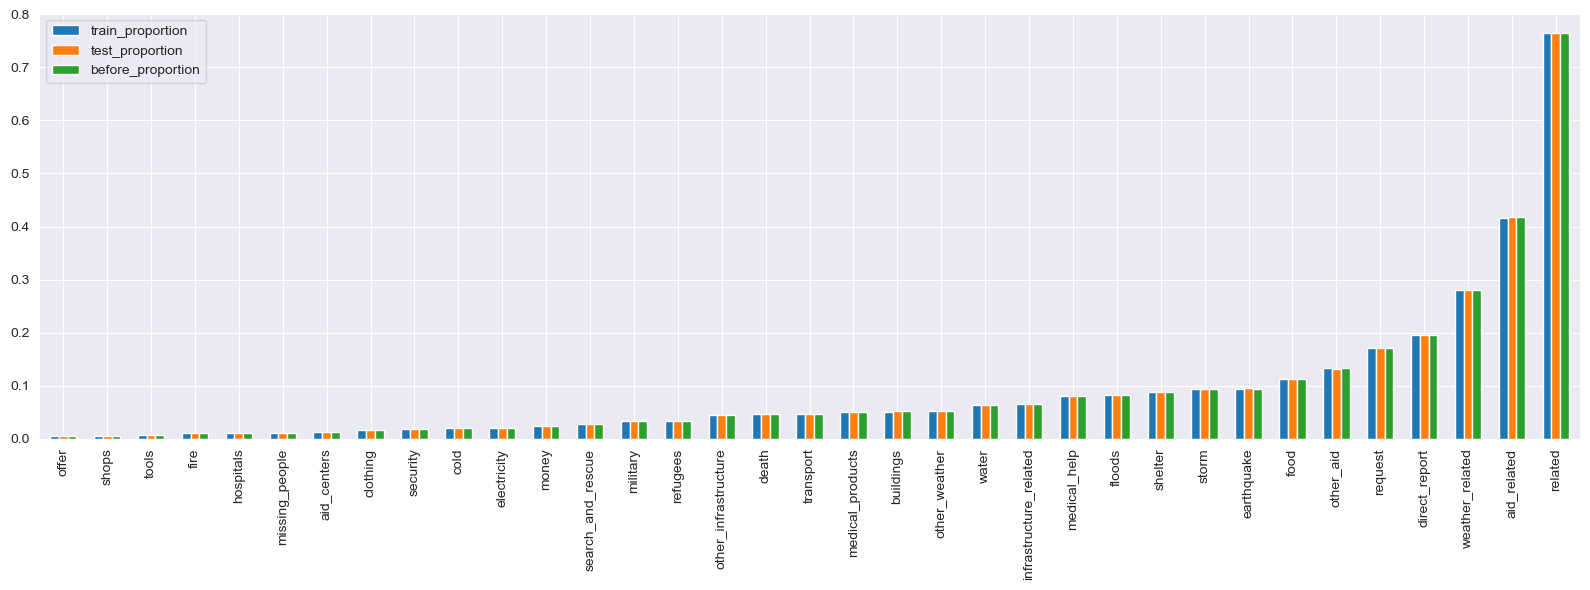

In [29]:
# make sure proportions are the same for original y, test and train datasets
# y_train_prop = (y_train.sum() / y_train.shape[0]).sort_values().to_frame()
# y_train_prop.columns = ['train_proportion']
# y_test_prop = (y_test.sum() / y_test.shape[0]).sort_values().to_frame()
# y_test_prop.columns = ['test_proportion']
# y_prop = (y.sum() / y.shape[0]).sort_values().to_frame()
# y_prop.columns = ['before_proportion']
# all = y_train_prop.merge(y_test_prop, left_index=True, right_index=True)
# all = all.merge(y_prop, left_index=True, right_index=True)
# all_index = all.index

# all.plot(kind='bar', width=0.6, sharey=True, sharex=True, stacked=False, figsize=(16,6))
# plt.tight_layout()

# make sure proportions are the same for original y, test and train datasets
def print_proportions(y, y_train, y_test):
    y_train_prop = (y_train.sum() / y_train.shape[0]).sort_values().to_frame()
    y_train_prop.columns = ['train_proportion']
    y_test_prop = (y_test.sum() / y_test.shape[0]).sort_values().to_frame()
    y_test_prop.columns = ['test_proportion']
    y_prop = (y.sum() / y.shape[0]).sort_values().to_frame()
    y_prop.columns = ['before_proportion']
    all = y_train_prop.merge(y_test_prop, left_index=True, right_index=True)
    all = all.merge(y_prop, left_index=True, right_index=True)
    all = all.reindex(y_prop.index)
    all.plot(kind='bar', width=0.6, sharey=True, sharex=True, stacked=False, figsize=(16,6))
    plt.tight_layout()

print_proportions(y, y_train, y_test)

> Label were split in the same proportions between train, validation and test datasets

In [30]:
# TODO
# now we need to oversample the minority classes

In [31]:
# # testing mlsmote, using nearest neighbors, does it make sense to use ?
# pipeline2 = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     # ('oversampling', RandomOverSampler(sampling_strategy='minority', random_state=random_state)),
#     ('oversampling', MLSMOTE(categorical_features=[0],
#                              input_columns=X_train.columns.to_list(), 
#                              label_columns=y_train.columns,
#                              random_state=77))   
# ])
# 
# X_train_transformed = pipeline2.fit_transform(X_train['message_new'])
# test = pd.DataFrame(X_train_transformed.toarray())
# 
# # Now lets over sample the minority classes
# categorical_features = test.columns.to_list()
# 
# # Create an instance of MLSMOTE
# mlsmote = MLSMOTE(categorical_features=[0],
#                   input_columns=test.columns.to_list(),
#                   label_columns=y_train.columns,
#                   random_state=random_state)
# 
# mlsmote.fit(test, y_train) 
# X_sub, y_sub = mlsmote.transform(test, y_train)
# 
# # Are there improvements in proportions ?
# y_train_prop = (X_sub.sum() / X_sub.shape[0]).sort_values().to_frame()
# y_train_prop.columns = ['train_proportion']
# y_test_prop = (y_sub.sum() / y_sub.shape[0]).sort_values().to_frame()
# y_test_prop.columns = ['test_proportion']
# y_prop = (y.sum() / y.shape[0]).sort_values().to_frame()
# y_prop.columns = ['before_proportion']
# all = y_train_prop.merge(y_test_prop, left_index=True, right_index=True)
# all = all.merge(y_prop, left_index=True, right_index=True)
# 
# all.plot(kind='bar', width=0.6, sharey=True, sharex=True, stacked=False, figsize=(16,6))
# plt.tight_layout()

In [32]:
def get_tail_label(y: pd.DataFrame) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurrence.
    """
    # irlbl = y.sum(axis=0)
    # irlbl = irlbl.max() / irlbl
    # threshold_irlbl = irlbl.mean()
    # tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    # print(tail_label)
    # return tail_label
   
    # irlbl = y.sum(axis=0)
    # print(irlbl)
    # irlbl = irlbl.max() / irlbl
    # threshold_irlbl = irlbl.mean()
    # tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    # print(tail_label)
    
    grand_total = y.sum(axis=0).sum()
    irlbl = y.sum(axis=0)/grand_total
    # threshold_irlbl = irlbl.median()
    threshold_irlbl = irlbl.quantile(0.25)
    tail_label = irlbl[irlbl < threshold_irlbl].index.tolist()     
    
    return tail_label


def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame):
    """
    Filter datasets containing records with imbalanced targets
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    X_sub = X.loc[index]
    y_sub = y.loc[index]
    print('Imbalanced labels: {}'.format(tail_labels))
    return X_sub, y_sub, tail_labels

def get_sample_ratio(df: pd.DataFrame):
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurrence.
    Targets beyond a quantile limit are filtered.
    """
    
    tail_labels = get_tail_label(df)
    full_count = df.sum(axis=0)    
    ratio = np.where(full_count.index.isin(tail_labels), np.ceil((full_count.mean()) / full_count), 1)    
    ratio = pd.Series(ratio, index=full_count.index)    
    return ratio  

def transform(X, y):
  
    # calculate the ratio each label should be duplicated to be balanced
    counts = get_sample_ratio(y_train)

    # filter datasets with rows that contain imbalanced features
    X_sub, y_sub, tail_labels = get_minority_samples(X, y)   
    print('Minority samples: {} {}'.format(X_sub.shape, y_sub.shape))
    
    # replace class binary indicator with it's ratio of duplication
    y_sub_copy = y_sub.copy()
    labels = y_sub.columns.to_list()
    for label in labels:
        # print(label, counts[label])
        y_sub_copy[label] = y_sub_copy[label].apply(lambda x: x * counts[label])    
    
    X_list = []
    y_list = []
    for i in range(y_sub.shape[0]):
        # for each row, get label with maximum ratio
        max_label = y_sub_copy.iloc[i].idxmax()
        # how many times should we copy this row ?
        nr_copies = int(counts[max_label])
        # get index of row to be copied
        index = y_sub.iloc[i].name
        # print(max_label, nr_copies, index)
        # duplicate the rows according to ratio of imbalance
        for _ in range(nr_copies):
            y_list.append(y_sub.iloc[i])
            X_list.append(X_sub.iloc[i])
           
    X_sub_new = pd.DataFrame(X_list, columns=X_train.columns.to_list())
    y_sub_new = pd.DataFrame(y_list, columns=y_train.columns.to_list())
    
    X_sub_new = pd.concat([X, X_sub_new])
    y_sub_new = pd.concat([y, y_sub_new])
    
    return X_sub_new, y_sub_new, tail_labels
    

In [33]:
# get_sample_ratio(y_train)

In [34]:
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = transform(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

Training shapes before: (17327, 2) (17327, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1384, 2) (1384, 35)
Duplicated samples: (30500, 2) (30500, 35)


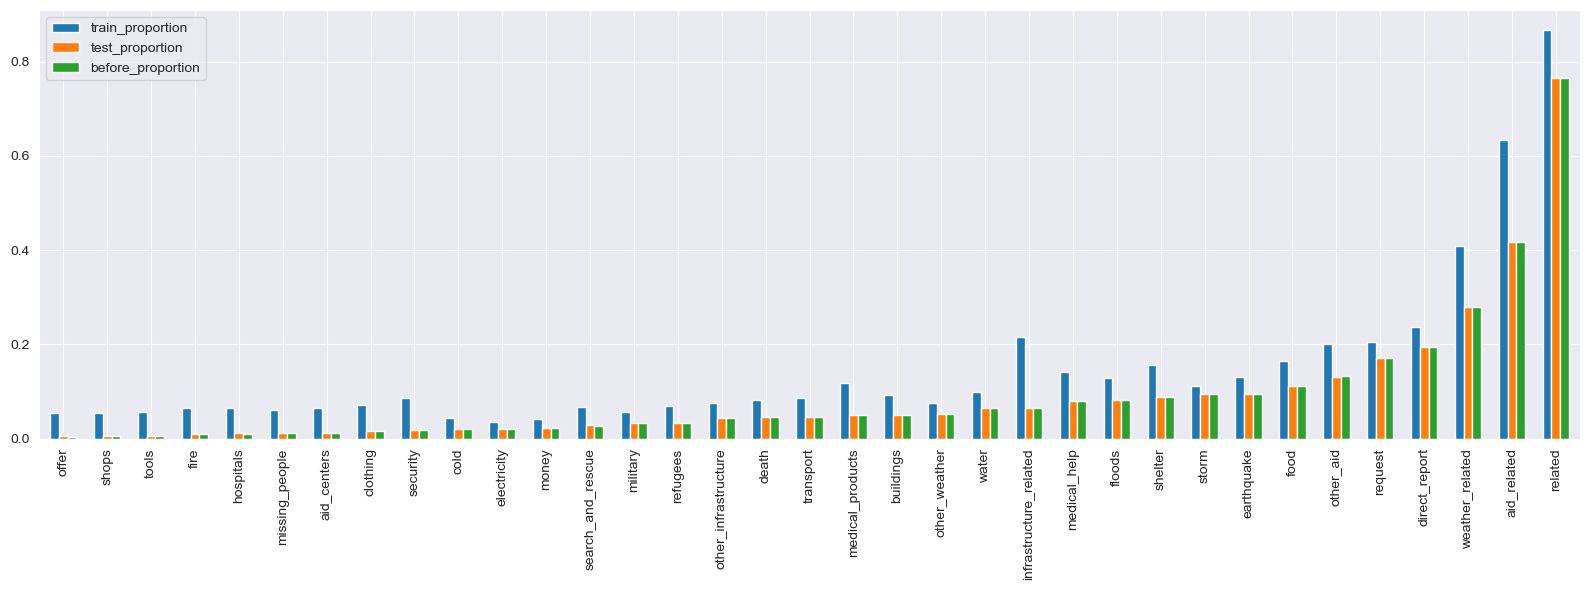

In [35]:
print_proportions(y, y_train_sub, y_test)

In [36]:
neg = y_train_sub[y_train_sub['offer'] == 0].count().sum()
pos = y_train_sub[y_train_sub['offer'] == 1].count().sum()
ratio = neg / pos

In [37]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = mkdtemp()
# memory = Memory(location=cachedir, verbose=1)

params = {
    'objective': 'binary:logistic',
    'n_jobs': 4,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    # 'eval_metric': 'error',    
    'booster': 'gbtree',
    # 'random_state': random_state,
    'n_estimators': 30,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'tree_method': 'hist',
    'scale_pos_weight': ratio,
    # 'device': 'gpu',
    # 'early_stopping_rounds': 15,
    'verbosity': 2,
    'seed' : random_state,
    'nthread': 4,
    # 'enable_categorical': True,

}

text_pipe = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None)),    
    ('tfidf', TfidfTransformer(sublinear_tf=True)),    
    # ('scale', StandardScaler(with_mean=False)),
    ],
    verbose=True)

# preprocessor for NLP
preprocessor_text = ColumnTransformer(transformers=[
    ('text_vect', text_pipe, 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

# preprocessor for genre column to convert to binary
preprocessor_bin = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),
],
    # verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

preprocessor = Pipeline([
    ('feature_union', FeatureUnion([

        ('text_processing', preprocessor_text),

        ('one_hot', preprocessor_bin),

    ],
        verbose=True, 
    ))])


full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultiOutputClassifier(xgb.XGBClassifier(**params))),
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
# train classifier
full_pipeline.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
y_pred_val = evaluate(X_val, y_val, full_pipeline)

In [ ]:
auc = roc_auc_score(y_val,
                    y_pred_val)
print('AUC aggregate: {}'.format(auc))

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
full_pipeline.get_params()

In [ ]:
hyperparameters = {
    'clf__estimator__max_depth' : [6, 8, 10],
    'clf__estimator__min_child_weight': [1, 3, 5]
    # 'clf__estimator__learning_rate': [0.1, 0.01, 0.05],
    # 'clf__estimator__alpha': [0.1, 1, 10],
    # 'clf__estimator__gamma': [0, 0.25, 1],
    # 'clf__estimator__reg_lambda': [0, 1, 10],
    # 'clf__estimator__n_estimators': [150,300],
    # 'clf__estimator__subsample': [0.8, 1],
    # 'clf__estimator__scale_pos_weight': [None, 1, 5],
    # 'clf__estimator__tree_method': ['hist'],
    # 'clf__estimator__colsample_bytree': [0.5, 0.8, 1],   
}

# labels = list(y_train_sub.columns)
# mls = MultilabelStratifiedKFold(n_splits=2,
#                                 shuffle=True,
#                                 random_state=random_state)

skf = StratifiedKFold(n_splits=2, shuffle=False)

# create grid search object
gsearch1 = GridSearchCV(full_pipeline,
                  param_grid=hyperparameters,
                  refit=True,
                  return_train_score=True,
                  # n_jobs=6,
                  scoring='roc_auc',
                  cv=MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0),
                  verbose=3,
                  )

gsearch1.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
# predict
y_pred_val = gsearch1.predict(X_val)

print(classification_report(y_val,
                            y_pred_val,
                            target_names=list(y.columns),
                            zero_division=0))

In [ ]:
auc = roc_auc_score(y_val, y_pred_val)
print('AUC aggregate: {}'.format(auc))
print('Best score: {}'.format(gsearch1.best_score_))

In [ ]:
print("\nBest Parameters:", gsearch1.best_params_)

In [ ]:
# clear cache
hyperparameters = {
    'clf__estimator__max_depth': [10],
    'clf__estimator__min_child_weight': [0.1, 1, 2, 5, 10],
    # 'clf__estimator__learning_rate': [0.1, 0.01, 0.05],
    # 'clf__estimator__alpha': [0.1, 1, 10],
    # 'clf__estimator__gamma': [0.1, 0, 1, 2, 3],
    # 'clf__estimator__reg_lambda': [0, 1, 10],
    # 'clf__estimator__n_estimators': [150,300],
    # 'clf__estimator__subsample': [0.8, 1],
    # 'clf__estimator__scale_pos_weight': [None, 1, 5],
    # 'clf__estimator__tree_method': ['hist'],
    # 'clf__estimator__colsample_bytree': [0.5, 0.8, 1],   
}

# create grid search object
gsearch2 = GridSearchCV(full_pipeline,
                        param_grid=hyperparameters,
                        refit=True,
                        return_train_score=True,
                        # n_jobs=6,
                        scoring='roc_auc',
                        cv=MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0),
                        verbose=3,
                        )

gsearch2.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

In [ ]:
# predict
# def evaluate(X, y, model):
# 
#     y_pred = model.predict(X)
#     
#     print(classification_report(y,
#                                 y_pred,
#                                 target_names=list(y.columns),
#                                 zero_division=0))
#     return y_pred

y_pred_val = evaluate(X_val, y_val, gsearch2)

In [ ]:
# def print_results(y, y_pred, cv):
# 
#     roc_auc = roc_auc_score(y, y_pred)
#     print('AUC aggregate: {}'.format(roc_auc))
#     print('\nBest score: {}'.format(cv.best_score_))
#     print("\nBest Parameters:", cv.best_params_)
#     print("\nScores: \n", cv.cv_results_)
    
print_results(y_val, y_pred_val, gsearch2)

## Step 3

In [ ]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = mkdtemp()
# memory = Memory(location=cachedir, verbose=1)

params = {
    'objective': 'binary:logistic',
    'n_jobs': 4,
    'max_depth': 10,
    'min_child_weight': 1,
    'gamma': 0,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    # 'eval_metric': 'error',    
    'booster': 'gbtree',
    # 'random_state': random_state,
    'n_estimators': 30,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'tree_method': 'hist',
    'scale_pos_weight': ratio,
    # 'device': 'gpu',
    # 'early_stopping_rounds': 20,
    'verbosity': 2,
    'seed': random_state,
    'nthread': 4,
    # 'enable_categorical': True,

}

text_pipe = Pipeline(steps=[
    # ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None, dtype=np.int16)),
    ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None)),
    # ('tfidf', TfidfTransformer(norm='l2')),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    # ('scale', StandardScaler(with_mean=False)),
],
    verbose=True)

# bin_pipe = Pipeline(steps=[
#     ('one-hot', OneHotEncoder()),
#     ],
#     verbose=True)

# preprocessor for NLP
preprocessor_text = ColumnTransformer(transformers=[
    ('text_vect', text_pipe, 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='drop',
)

# preprocessor for genre column to convert to binary
preprocessor_bin = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),
],
    # verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

preprocessor = Pipeline([
    ('feature_union', FeatureUnion([

        ('text_processing', preprocessor_text),

        ('one_hot', preprocessor_bin),

    ],
        verbose=True,
    ))])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultiOutputClassifier(xgb.XGBClassifier(**params))),
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
hyperparameters = {
    # 'clf__estimator__max_depth': [10],
    # 'clf__estimator__min_child_weight': [1],
    # 'clf__estimator__learning_rate': [0.1, 0.01, 0.05],
    # 'clf__estimator__alpha': [0.1, 1, 10],
    'clf__estimator__gamma': [0.001, 0.1, 0, 1, 10, 100],
    # 'clf__estimator__reg_lambda': [0, 1, 10],
    # 'clf__estimator__n_estimators': [150,300],
    # 'clf__estimator__subsample': [0.8, 1],
    # 'clf__estimator__scale_pos_weight': [None, 1, 5],
    # 'clf__estimator__tree_method': ['hist'],
    # 'clf__estimator__colsample_bytree': [0.5, 0.8, 1],   
}

# create grid search object
gsearch3 = GridSearchCV(full_pipeline,
                        param_grid=hyperparameters,
                        refit=True,
                        return_train_score=True,
                        # n_jobs=6,
                        scoring='roc_auc',
                        cv=MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=0),
                        verbose=3,
                        )

gsearch3.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

In [ ]:
y_pred_val = evaluate(X_val, y_val, gsearch3)

In [ ]:
print_results(y_val, y_pred_val, gsearch3)

In [ ]:
gsearch3.best_params_['clf__estimator__gamma']

In [ ]:
full_pipeline.set_params(clf__estimator__gamma=gsearch3.best_params_['clf__estimator__gamma'])

## Step 4

Use GridSearchCV for hyper parameter training, however use the validation dataset for evaluation to avoid data leakage.

Because the eval_set needs to be transformed first, I use PredinedSplit so that the validation dataset is transformed internally.

In [ ]:
# X_train_transformed = full_pipeline[:-1].transform(X_train)
# X_train_transformed.shape

In [ ]:
hyperparameters = {
    # 'clf__estimator__max_depth': [10],
    # 'clf__estimator__min_child_weight': [1],
    # 'clf__estimator__learning_rate': [0.1, 0.01, 0.05],
    # 'clf__estimator__alpha': [0.1, 1, 10],
    'clf__estimator__gamma': [0, 10, 30, 35, 40, 45, 50, 60], 
    # 'clf__estimator__reg_lambda': [0, 1, 10],
    # 'clf__estimator__n_estimators': [150,300],
    # 'clf__estimator__subsample': [0.8, 1],
    # 'clf__estimator__scale_pos_weight': [None, 1, 5],
    # 'clf__estimator__tree_method': ['hist'],
    # 'clf__estimator__colsample_bytree': [0.5, 0.8, 1],   
}

# Build a predefined split with validation set to be used for evaluation

# Merge training and validation set back together
X_train_val_sub = pd.concat([X_train_sub, X_val])
y_train_val_sub = pd.concat([y_train_sub, y_val])

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [0 if x in X_val.index else -1 for x in X_train_val_sub.index]
pds = PredefinedSplit(test_fold=split_index)
print('Number of splits: {}'.format(pds.get_n_splits()))

# create grid search object
gsearch4 = GridSearchCV(full_pipeline,
                        param_grid=hyperparameters,
                        refit=False,
                        return_train_score=True,
                        n_jobs=4,
                        scoring='roc_auc',
                        # cv=MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0),
                        cv=pds,       
                        verbose=3,
                        )

# compare results of both training and validation datasets
# eval_set = [(X_train_val_sub, y_train_val_sub)]
gsearch4.fit(X_train_val_sub, y_train_val_sub)

print('\nBest score: {}'.format(gsearch4.best_score_))
print("\nBest Parameters:", gsearch4.best_params_)

print("\nScores: \n", gsearch4.cv_results_)
keys = []
shapes = []
examples = []
for key in list(cv.cv_results_.keys()):
    keys.append(key)
    shapes.append(len(cv.cv_results_.get(key)))
    examples.append(cv.cv_results_.get(key)[0])

df_results_info = pd.DataFrame({'size': shapes, 'example': examples}, index=keys)
print(df_results_info)

rmtree(cachedir)

In [38]:
def cv_predefined(X_train, y_train, X_val, y_val, pipeline, scoring='roc_auc', verbose=3):

    hyperparameters = {
        'clf__estimator__gamma': [0, 10, 30, 35, 40, 45, 50, 60], 
    }
    
    # Build a predefined split with validation set to be used for evaluation
    
    # Merge training and validation set back together
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [0 if x in X_val.index else -1 for x in X_train_val.index]
    pds = PredefinedSplit(test_fold=split_index)
    print('Number of training splits: {}'.format(pds.get_n_splits()))
    
    # create grid search object
    gridsearch = GridSearchCV(pipeline,
                      param_grid=hyperparameters,
                      refit=False,
                      return_train_score=True,
                      # n_jobs=4,
                      scoring=scoring,
                      # cv=MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0),
                      cv=pds,       
                      verbose=verbose,
                      error_score='raise'
                      )
    
    # compare results of both training and validation datasets
    gridsearch.fit(X_train_val, y_train_val)
    
    print('\nBest score: {}'.format(gridsearch.best_score_))
    print("\nBest Parameters:", gridsearch.best_params_)
    
    rmtree(cachedir)
    
    return gridsearch

In [39]:
gridsearch5 = cv_predefined(X_train_sub,
                            y_train_sub,
                            X_val,
                            y_val,
                            full_pipeline,
                            scoring='roc_auc',
                            verbose=3)

Number of training splits: 1
Fitting 1 folds for each of 8 candidates, totalling 8 fits
[Pipeline] .............. (step 1 of 2) Processing vect, total=   7.0s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.0s
[ColumnTransformer] ..... (1 of 1) Processing text_vect, total=   7.0s
[FeatureUnion]  (step 1 of 2) Processing text_processing, total=   7.0s
[ColumnTransformer] ....... (1 of 1) Processing one_hot, total=   0.0s
[FeatureUnion] ....... (step 2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   7.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.6min
[CV] END ............................clf__estimator__gamma=0; total time= 1.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.5min
[CV] END ...........................clf__estimator__gamma=10; total time= 1.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[CV] END ...........................clf

In [44]:
keys = []
shapes = []
examples = []
for key in list(gridsearch5.cv_results_.keys()):
    keys.append(key)
    shapes.append(len(gridsearch5.cv_results_.get(key)))
    examples.append(gridsearch5.cv_results_.get(key)[0])

df_results_info = pd.DataFrame({'size': shapes, 'example': examples}, index=keys)
df_results_info

,size,example
mean_fit_time,8,101.5028362274169921875
std_fit_time,8,0.0
mean_score_time,8,1.428679943084716796875
std_score_time,8,0.0
param_clf__estimator__gamma,8,0
params,8,{'clf__estimator__gamma': 0}
split0_test_score,8,0.78156282183464131918526618392206728458404541015625
mean_test_score,8,0.78156282183464131918526618392206728458404541015625
std_test_score,8,0.0
rank_test_score,8,7


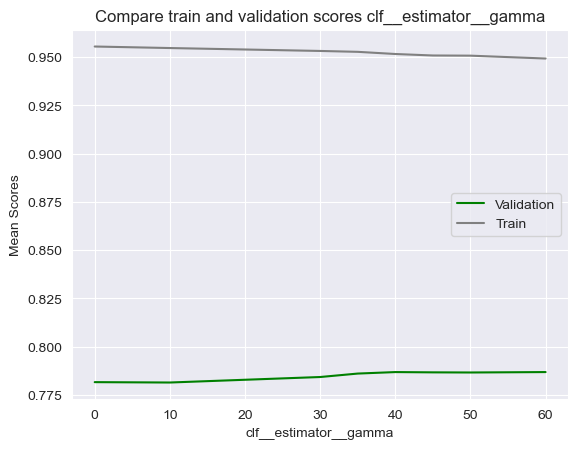

In [46]:
rows = len(gridsearch5.best_params_)
fig, axes = plt.subplots(nrows = rows, ncols = 1, sharex = True, sharey = True)

for i, ax in enumerate(fig.axes):

    param = next(iter(gridsearch5.best_params_))
    gammas = list(gridsearch5.cv_results_.get('param_' + param))
    mean_test_scores = list(gridsearch5.cv_results_.get('mean_test_score'))
    mean_train_scores = list(gridsearch5.cv_results_.get('mean_train_score'))
    
    sns.lineplot(x=gammas, y=mean_test_scores, color = 'green', label='Validation', ax=ax)
    sns.lineplot(x=gammas, y=mean_train_scores, color="grey", label='Train', ax=ax)
    plt.ylabel('Mean Scores')
    plt.xlabel(param)
    plt.legend()
    plt.title('Compare train and validation scores {}'.format(param))
    plt.show()

In [ ]:
# Update model parameters and refit with training datasets
full_pipeline.set_params(**gsearch4.best_params_)
full_pipeline.fit(X_train_sub, y_train_sub)
y_pred_val = evaluate(X_val, y_val, full_pipeline)
print_results(y_val, y_pred_val, full_pipeline)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

## Let's try sagemaker

In [ ]:
from src.helper import *


In [ ]:
# preprocessor.set_output(transform="pandas")

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train_sub)

X_train_transformed = pd.DataFrame(
    X_train_transformed.toarray(),
    index=X_train_sub.index)

X_train_transformed.shape

In [ ]:
X_val_transformed = preprocessor.transform(X_val)
# X_val_transformed = X_val_transformed.astype('float32')
print(X_val_transformed.shape)

X_val_transformed = pd.DataFrame(
    X_val_transformed.toarray(),
    index=X_val.index)

In [ ]:
X_val_transformed2 = X_val_transformed.add_suffix('_col')

max_decimals = 0
max_col = ''
for col in list(X_val_transformed2.columns.values):
    # print('Column {}'.format(col))
    mycount = X_val_transformed2[col].astype('str').str.split('.', expand=True)[1].apply(lambda x: len(x))  
    if mycount.max() > max_decimals:
        max_col = col
        max_decimals = mycount.max()
        
print('max decimals is: {}'.format(max_decimals))
print('max col is: {}'.format(max_col))

In [ ]:
X_val_transformed2['2_col'].dtype

In [ ]:
X_val_transformed2 = X_val_transformed2.astype('float32')

In [ ]:
X_val_transformed2['2_col'].max()

In [ ]:
train_location, df = make_train_csv(X=X_train_transformed, 
                                    y=y_train_sub.copy(), 
                                    prefix=prefix, 
                                    local_path=path_train, 
                                    filename=filename_train_csv,
                                    sagemaker_session=sagemaker_session,
                                    bucket=bucket)
df.head()

In [ ]:
validation_location, df = make_train_csv(X=X_val_transformed, 
                                         y=y_val, 
                                         prefix=prefix, 
                                         local_path=path_validation, 
                                         filename=filename_validation_csv,
                                         sagemaker_session=sagemaker_session,
                                         bucket=bucket)                                         
df.head()

In [ ]:
test_location = make_test_csv(X=X_val_transformed,
                              prefix=prefix, 
                              local_path=path_validation_test, 
                              filename=filename_test_csv,
                              sagemaker_session=sagemaker_session,
                              bucket=bucket)

test_location

In [ ]:
path_train

In [ ]:
path_validation

In [ ]:
# load training and testing files from locally stored csv files and store in DMatrix format
# label_column specifies the index of the column containing the true label
dtrain = xgb.DMatrix(os.path.join(path_train, 'train.csv?format=csv&label_column=0'))
# dtest = xgb.DMatrix(os.path.join(path_validation, 'validation.csv?format=csv&label_column=0'))

In [ ]:
dtrain

In [ ]:
# load training and testing files from locally stored csv files and store in DMatrix format
# label_column specifies the index of the column containing the true lab
dtest = xgb.DMatrix(os.path.join(path_validation, 'validation.csv?format=csv&label_column=0'))

In [ ]:
X_val_transformed.info(show_counts=None)

In [ ]:
np.any(np.isnan(X_val_transformed))

In [ ]:
np.any(np.isinf(X_val_transformed))

In [ ]:
np.all(np.isfinite(X_val_transformed))

In [ ]:
# Import required libraries 

# import pandas as pd 
# import numpy as np 
# 
# # Create dataframe using dictionary 
# data = {'Student ID': [10, 11, 12, 13, 14], 
# 		'Age': [23, 22, 24, 22, 25], 
# 		'Weight': [66, 72, np.inf, 68, -np.inf]} 
# 
# df = pd.DataFrame(data) 
# 
# display(df) 
# 
# # checking for infinity 
# print() 
# print("checking for infinity") 
# 
# printing the count of infinity values 
print("\nprinting the count of infinity values") 
# 
count = np.isinf(X_val_transformed).values.sum() 
print("It contains " + str(count) + " infinite values") 

# printing column name where infinity is present 
print("\nprinting column name where infinity is present") 
col_name = X_val_transformed.columns.to_series()[np.isinf(X_val_transformed).any()] 
print(col_name) 
# 
# # printing row index with infinity 
# print() 
# print("printing row index with infinity ") 
# 
# r = df.index[np.isinf(df).any(1)] 
# print(r) 


In [ ]:
# X_val_transformed = X_val_transformed.replace([np.inf, -np.inf], np.nan)

In [ ]:
xgb.DMatrix(os.path.join(path_validation, 'validation.csv?format=csv&label_column=0'))

In [ ]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'eta': 0.1,  
    'booster': 'gbtree',
    # 'n_estimators': 200,
    'subsample': 1,
    'colsample_bytree': 1,
    'tree_method': 'hist',
    'scale_pos_weight': 17,
    # 'device': 'gpu',
    'early_stopping_rounds': 30,
    'num_round': 100,
    'seed' : random_state,
    # 'enable_categorical': True,

}

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
# xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.3-1")
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# construct a SageMaker estimator that calls the xgboost-container
xgb_model = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=params,
                                          role=sagemaker_role,
                                          instance_count=1, 
                                          instance_type='ml.m5.xlarge', 
                                          volume_size=20, # GB size
                                          output_path=output_path,
                                          # enable_categorical=True, 
                                          # use_label_encoder=False, 
                                          base_job_name="disaster-pipeline",
#                                           rules=rules,
                                         )

In [ ]:
# Set hyperparameter ranges
hyperparameter_ranges = {
                        'eta': ContinuousParameter(0.1, 0.2),  
                        'min_child_weight': ContinuousParameter(8,20),
                        'max_depth': IntegerParameter(1, 3),
                        'alpha': ContinuousParameter(300, 400), 
                        'lambda': ContinuousParameter(8, 40), # L2
                        'gamma':ContinuousParameter(10, 40),  
                        'max_delta_step': ContinuousParameter(8, 20), 
                        'colsample_bytree': ContinuousParameter(0.6, 0.8),
                        }

# set the metric
objective_metric_name = 'validation:auc'

# Define hyper parameter job
xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb_model,
                                               objective_metric_name=objective_metric_name,
                                               objective_type='Maximize',
                                               hyperparameter_ranges=hyperparameter_ranges,
                                               max_jobs = 12,
                                               max_parallel_jobs = 3,
                                               early_stopping_type = 'Auto')

In [ ]:
# define the data type and paths to the training and validation datasets in S3
# content_type = "application/x-parquet"
content_type = "text/csv"
train_input = TrainingInput(train_location, content_type=content_type)
validation_input = TrainingInput(validation_location, content_type=content_type)

# execute the XGBoost training job
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

# execute the XGBoost hyper parameter tuning job
# xgb_hyperparameter_tuner.fit({"train": train_input, "validation": validation_input}, wait=True)

In [ ]:
xgb_transformer = xgb_model.transformer(instance_count = 1, 
                                        instance_type = 'ml.m4.xlarge')

In [ ]:
xgb_transformer.transform(test_location, content_type=content_type, split_type='Line', wait=True)

In [ ]:
# copy the model prediction from S3 to local environment for easier further analysis
!aws s3 cp --recursive $xgb_transformer.output_path $path_output

In [ ]:
def evaluate(path_output, y):
       
    # get predictions
    y_pred = pd.read_csv(os.path.join(path_output, 'test.csv.out'), header=None) 
    
    # round probability predictions to calculate the accuracy
    predictions = [round(num) for num in y_pred.squeeze().values]
    print('Accuracy: {}'.format(accuracy_score(y_validate.reset_index(drop=True), predictions)))
    
    # print confusion metrix
    print('\nConfusion matrix : \n{}'.format(confusion_matrix(y_validate, predictions)))
    
    # ROC needs that we pass the probability
    # https://stackoverflow.com/questions/62192616/strange-behavior-of-roc-auc-score-roc-auc-auc
    print('\nAUC: {}'.format(roc_auc_score(y, y_pred)))

In [ ]:
evaluate(path_output, y_val)

In [ ]:
# add dummy variable

pipeline = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None)),
            ('tfidf', TfidfTransformer()),

        ])),

        ('starting_verb', StartingVerbExtractor2())

    ])),

    ('clf', MultiOutputClassifier(xgb.XGBClassifier(**params))),
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
# XGBOOST have a multilabel predictor build, how does that perform ?

# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label == 1)
#     param["scale_pos_weight"] = ratio
#     return (dtrain, dtest, param)


# do cross validation, for each fold
# the dtrain, dtest, param will be passed into fpreproc
# then the return value of fpreproc will be used to generate
# results of that fold
# param = {"max_depth": 2, "eta": 1, "objective": "binary:logistic"}

param = {
    'max_depth' : [8, 12, 20], 
}
num_round = 2

res = xgb.cv(param,
             X_train_sub['message_new'],
             num_boost_round=2,
             nfold=5,
             metrics={"auc"},
             seed=0,
             scoring='f1_micro',
             stratified=True,
             callbacks=[
                xgb.callback.EvaluationMonitor(show_stdv=False),
                xgb.callback.EarlyStopping(3),
                 ]
             )


### 9. Export your model as a pickle file

In [ ]:
# delete the temporary cache before exiting
rmtree(cachedir)

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

https://cookbook.openai.com/examples/batch_processing

https://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label

https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat

https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote

[Oversampling](https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification)

[Creating Balanced Multi-Label Datasets for Model Training and Evaluation](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)


[MLSMOTE for MoA](https://www.kaggle.com/code/yassinealouini/mlsmote-for-moa)

[Creating balanced multilabel datasets comparing multiple libraries](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

[xgboost for LLMS](https://www.kaggle.com/code/vbmokin/llm-20-feature-xgboost-after-deobfuscation/notebook

[How to use xgboost multi label](https://xgboost.readthedocs.io/en/latest/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py)

[XGBOOST is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook)

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

[Mastering XGBoost Parameters Tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

[Nested pipelines](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c)

[Using predefined split during cross validation](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)

[Using GridSearchCV to validate against validation dataset](https://stackoverflow.com/questions/46815252/using-scikit-learn-gridsearchcv-for-cross-validation-with-predefinedsplit-susp)

[Plotting training vs validation cross validation scores](https://www.kaggle.com/code/willcanniford/predicting-back-pain-with-sklearn-and-gridsearchcv)

Sagemaker
https://subscription.packtpub.com/book/data/9781801817950/2/ch02lvl1sec05/setting-up-amazon-sagemaker-on-your-local-machine